In [1]:
import json
import numpy as np
import pandas as pd
import uproot
import matplotlib.pyplot as plt
import mplhep as mh

from hist.hist import Hist
from hist.axis import Regular

from RPCGeomServ import RPCRoll

In [33]:
def get_eff_list(path_input, path_roll_blacklist, where):
    if path_roll_blacklist is None:
        roll_blacklist = set()
    else:
        with open(path_roll_blacklist) as stream:
            roll_blacklist = set(json.load(stream))

    h_total = uproot.open(f"{path_input}:total").to_hist()
    h_passed = uproot.open(f"{path_input}:passed").to_hist()

    roll_axis = h_total.project("xaxis").axes[0]
    roll_name_list = [roll_axis.value(idx) for idx in range(roll_axis.size)]

    run_axis = h_total.project("yaxis").axes[0]
    run_list = [run_axis.value(idx) for idx in range(run_axis.size)]


    total_2d = h_total[roll_name_list, :].values()
    passed_2d = h_passed[roll_name_list, :].values()
    eff_2d = np.divide(passed_2d, total_2d, out=np.zeros_like(total_2d), where=(total_2d > 0))

    is_barrel = np.vectorize(lambda item: item.startswith('W'))

    barrel_mask = is_barrel(roll_name_list)
    endcap_mask = np.logical_not(barrel_mask)

    is_whitelist = np.vectorize(lambda item: item not in roll_blacklist)
    whitelist_mask = is_whitelist(roll_name_list)

    eff_mean_list, eff_rms_list, masked_run_list = [], [], []

    for idx in range(len(run_list)):
        run = run_list[idx]
        eff = eff_2d[:, idx]

        if where == "barrel": eff = eff[barrel_mask & whitelist_mask] * 100
        if where == "endcap": eff = eff[endcap_mask & whitelist_mask] * 100
        if where == "any": eff = eff[whitelist_mask] * 100

        eff_mean = np.mean(eff[eff > 70])

        if eff_mean > 0:
            masked_run_list.append(run)
            eff_mean_list.append(np.mean(eff[eff > 70]))
            eff_rms_list.append(np.std(eff[eff > 70]))

    return eff_mean_list, masked_run_list

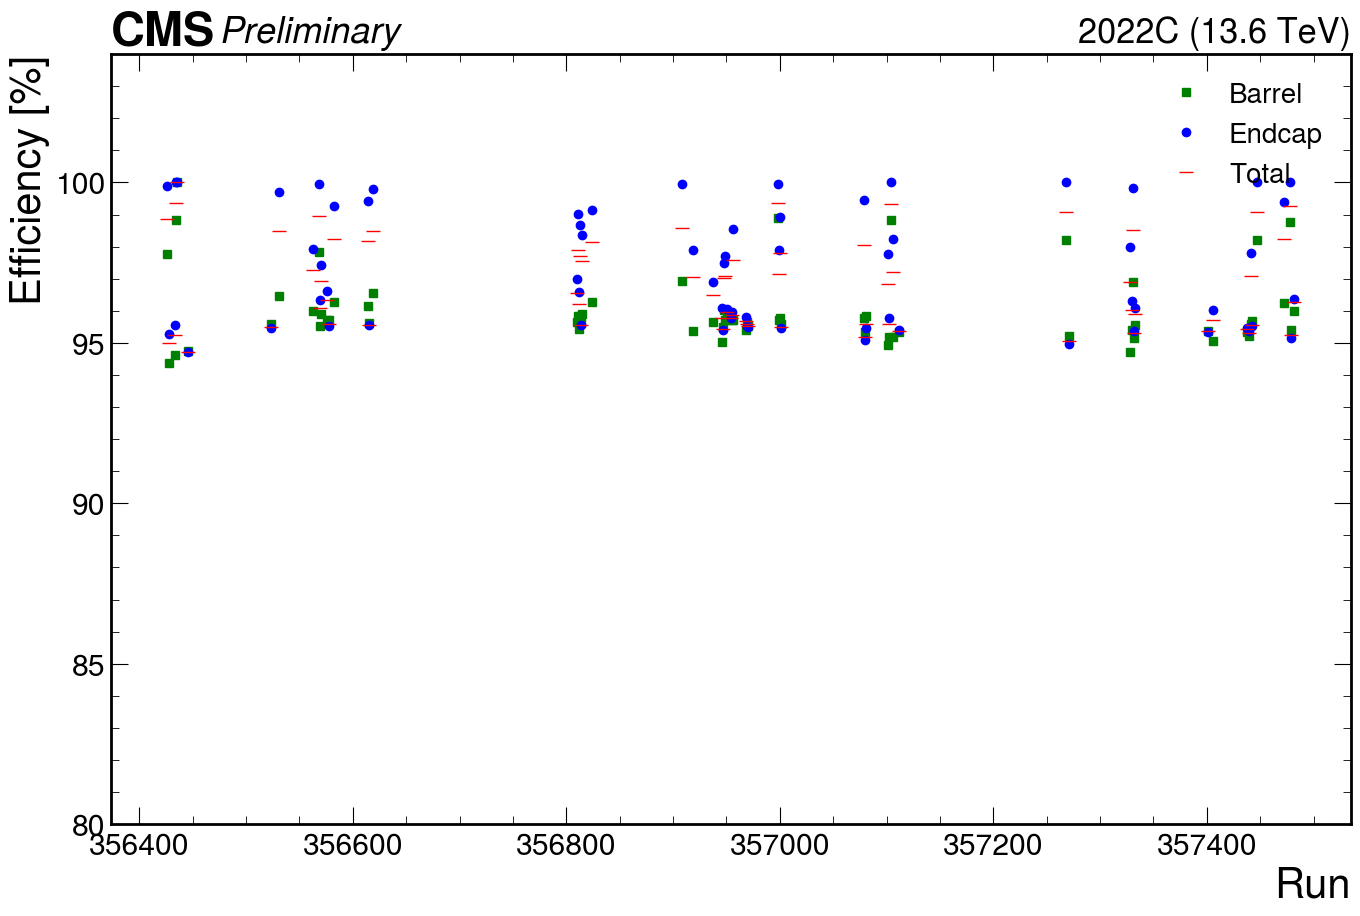

In [41]:
path_input = "/home/sourcemaru/OneDrive/RPC/TnP/Workspace/data/tnp-nanoaod-flatten-2d/Muon__Run2022C.root"
path_roll_blacklist = "../data/roll-blacklist.json"    

barrel_effs, runs = get_eff_list(path_input, path_roll_blacklist, "barrel")
endcap_effs, runs = get_eff_list(path_input, path_roll_blacklist, "endcap")
effs, runs = get_eff_list(path_input, path_roll_blacklist, "any")

    
fig, ax = plt.subplots(figsize=(16, 10))
ax.set_xlabel("Run", fontsize=30) # type: ignore
ax.set_ylabel("Efficiency [%]", fontsize=30) # type: ignore
ax.set_ylim(80, 104)
mh.style.use(mh.styles.CMS)
mh.cms.label(ax=ax, llabel=label, com=com, year=year)

label = f'Preliminary'
com = 13.6
year = "2022C"

ax.plot(runs, barrel_effs, "s", markersize=6, color="green", label="Barrel")
ax.plot(runs, endcap_effs, "o", markersize=6, color="blue", label="Endcap")
ax.plot(runs, effs, "_", markersize=10, color="red", label="Total")

ax.legend(fontsize=20, loc='upper right')

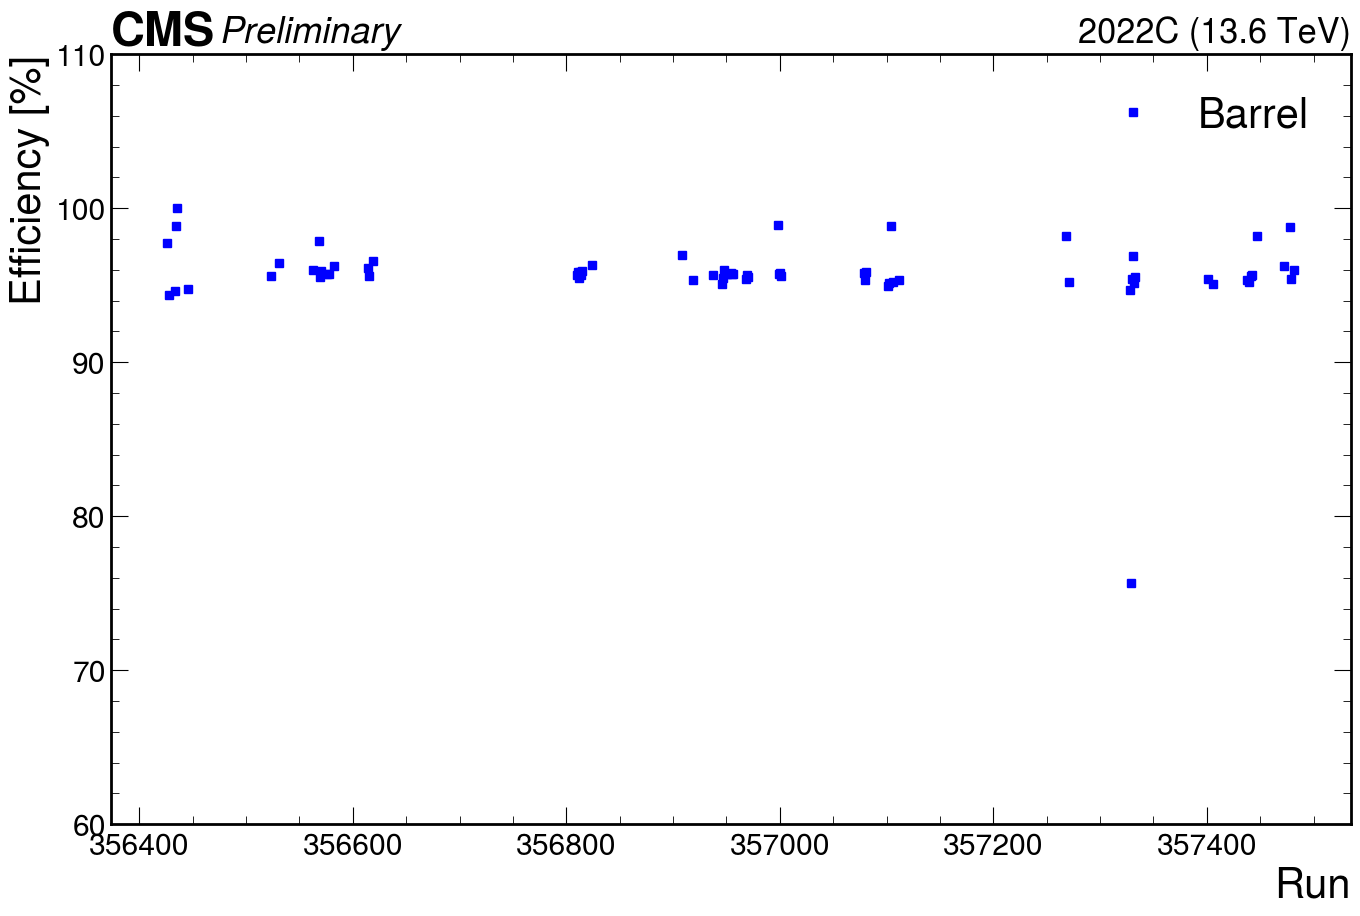

In [30]:
fig, ax = plt.subplots(figsize=(16, 10))

ax.set_xlabel("Run", fontsize=30) # type: ignore
ax.set_ylabel("Efficiency [%]", fontsize=30) # type: ignore


label = f'Preliminary'
com = 13.6
year = "2022C"

mh.style.use(mh.styles.CMS)
mh.cms.label(ax=ax, llabel=label, com=com, year=year)
#ax.errorbar(masked_run_list, eff_mean_list, yerr=eff_rms_list, linewidth=3, c="black", label="Barrel")
#ax.errorbar(
#    masked_run_list,
#    eff_mean_list,
#    yerr = eff_rms_list,
#    fmt="s",
#    markersize=6,
#    linewidth=2,
#    capsize=4,
#    capthick=2,
#    color="blue",
#    label="Barrel",
#)

ax.plot(
    masked_run_list,
    eff_mean_list,
    "s",
    markersize=6,
    color="blue",
    label="Barrel"
)
ax.set_ylim(60, 110)
ax.legend(fontsize=30, loc='upper right')

NameError: name 'mean_eff' is not defined

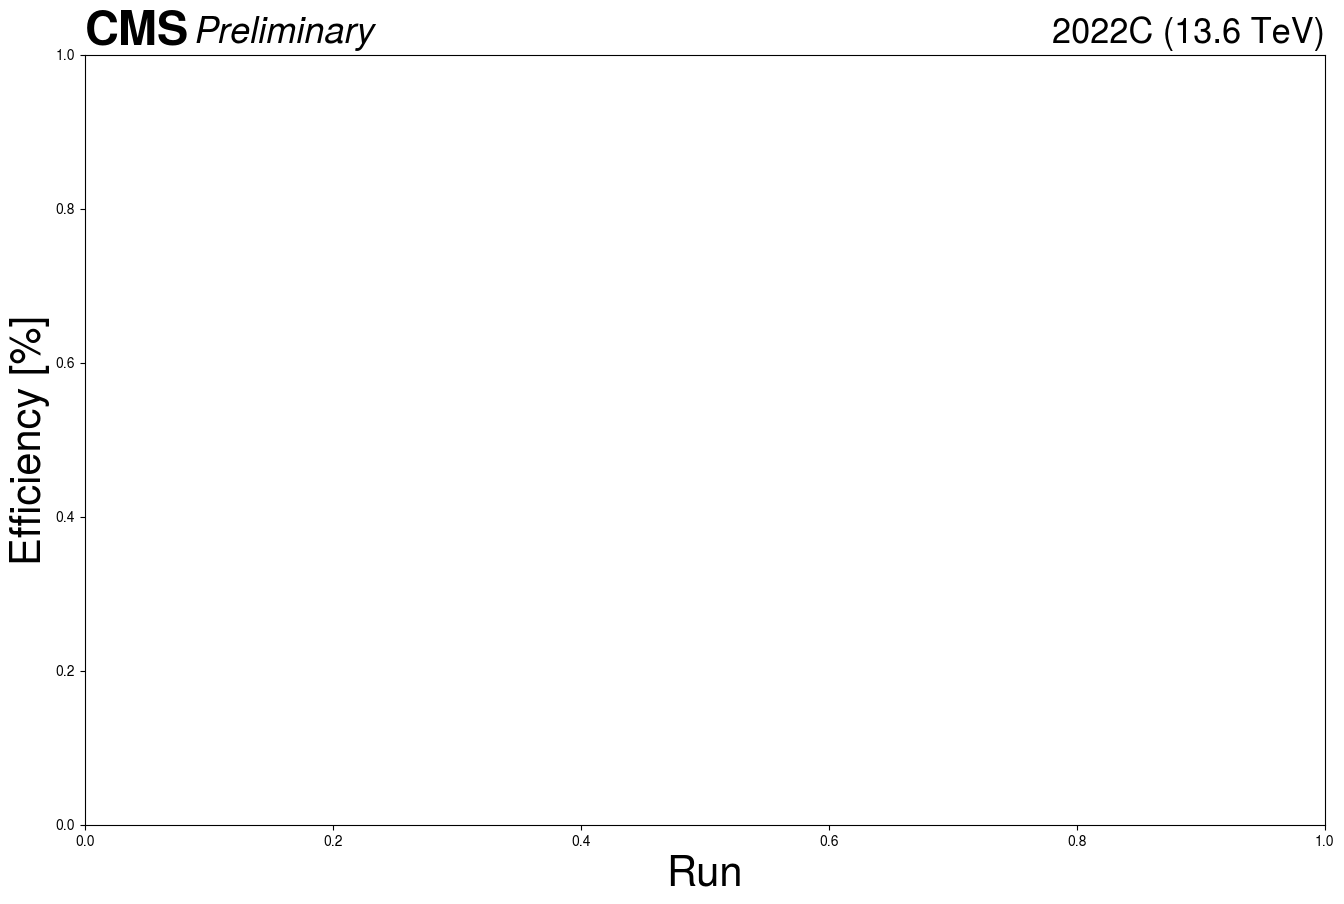

In [3]:
fig, ax = plt.subplots(figsize=(16, 10))

ax.set_xlabel("Run", fontsize=30) # type: ignore
ax.set_ylabel("Efficiency [%]", fontsize=30) # type: ignore


label = f'Preliminary'
com = 13.6
year = "2022C"

mh.style.use(mh.styles.CMS)
mh.cms.label(ax=ax, llabel=label, com=com, year=year)
ax.plot(run, mean_eff*100, linewidth=3, c="black", label="Total")
ax.plot(run, mean_barrel_eff*100, linewidth=3, c="blue", label="Barrel")
ax.plot(run, mean_endcap_eff*100, linewidth=3, c="green", label="Endcap")

ax.legend(fontsize=30, loc='upper right')